In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML


/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
episode_length = 30
seed = 42

system = PDSystemEnv()
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)

state = env.reset()
state

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([ 35.58499034, 171.27643223,  67.48749111])

In [3]:
a = np.array([1,0,2,0,5])
np.argmin(a)

1

In [4]:
min_boolean_indexes = np.isin(a, np.min(a))
min_indexes = np.where(min_boolean_indexes)
min_indexes[0]

array([1, 3])

In [5]:
def emptiest_tank_policy(s, system):
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]
    #n_min = len(min_indexes)

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        #print(hypothetical_next_tank_state, system.tank_max_loads[tank_visited])
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = random.choice(possible_indexes)
        return np.array([tank_to_go])
    else:
        return np.array([system.n]) #stay in the depot

In [6]:
a = emptiest_tank_policy(state, system)
a

array([0])

In [7]:
state2, r, terminal, info = env.step(a)
state2

array([ 69.08499034, 167.27643223,  56.98749111])

# The trivial policy (simple hard-coded policy)

In [8]:
frames = []

n_episodes = 1

for episode in range(n_episodes):
    state = env.reset()
    for step in range(episode_length):
        system.state = state
        img = system.visualize()
        frames.append(img)

        action = emptiest_tank_policy(state, system)

        state, reward, done, info = env.step(action)
        if done:
            break

test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

    #plot_animation(frames)

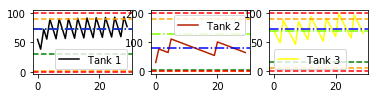

In [9]:
plt.close()

#THE REAL LEVELS (percentages 12h, 36h, ? h)
tank_levels = [frames[i][2] for i in range(len(frames))]
tank_levels_array = np.asarray(tank_levels).transpose()

n = system.n

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks_max_load = system.tank_max_loads
level_percentages = system.load_level_percentages

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, level_percentages[i-1]):
        plt.axhline(y= lvl * tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = level_percentages[i-1]           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
    
    plt.legend(loc='best')
plt.show()


In [10]:
test_anim


# Neural Network Policies

In [11]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Initilized neural network policy

In [12]:
reset_graph()

episode_length = 30
seed = 45

system = PDSystemEnv()
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)

# 1. Parameters to determine the NN architecture

n_inputs = env.observation_space.shape[1]
n_hidden1 = 20; activation1 = tf.nn.elu
n_hidden2 = 6; activation2 = tf.nn.elu
n_outputs = env.action_space.shape[1]

initializer = tf.contrib.layers.variance_scaling_initializer()

# 2. Build the Neural Network

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                         kernel_initializer = initializer)
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                         kernel_initializer = initializer)
logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer)

outputs = tf.nn.softmax(logits)

# 3. Select a random action (where to go) based on the estimated probabilities
action = tf.multinomial(tf.log(outputs), num_samples = 1)

init = tf.global_variables_initializer()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
Use the retry module or similar alternatives.


In [13]:
frames = []
n_episodes = 1

with tf.Session() as sess:
    init.run()
    for episode in range(n_episodes):
        state = env.reset()
        for step in range(episode_length):
            system.state = state
            img = system.visualize()
            frames.append(img)

            action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
            state, reward, done, info = env.step(action_val[0])
            if done:
                break

env.close()

test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())




## Training neural network policy

In [57]:
reset_graph()

episode_length = 30
seed = 45

system = PDSystemEnv()
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)

# 1. Parameters to determine the NN architecture and hyperparameters
learning_rate = 0.01
mean = tf.constant(0.0)
variance = tf.constant(1.0)
offset = tf.constant(0.0)
scale = tf.constant(1.0)
variance_epsilon = tf.constant(10**(-6))



n_inputs = env.observation_space.shape[1]
n_hidden1 = 20; activation1 = tf.nn.elu
n_hidden2 = 6; activation2 = tf.nn.elu
n_outputs = env.action_space.shape[1]

initializer = tf.contrib.layers.variance_scaling_initializer()

# 2. Build the Neural Network

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

X_min = tf.reduce_min(X)
X_max = tf.reduce_max(X)

X_rescaled = tf.div( tf.subtract(X,X_min), tf.add(X_max, X_min) ) 

hidden1 = tf.layers.dense(X_rescaled, n_hidden1, activation = activation1,
                         kernel_initializer = initializer)
#hidden1 = tf.nn.batch_normalization(hidden1, mean, variance, offset, scale, variance_epsilon)

hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                         kernel_initializer = initializer)
#hidden2 = tf.nn.batch_normalization(hidden2, mean, variance, offset, scale, variance_epsilon)

logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer)

outputs = tf.nn.softmax(logits)

# 3. Select a random action (where to go) based on the estimated probabilities
action = tf.multinomial(tf.log(outputs), num_samples = 1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)



init = tf.global_variables_initializer()
saver = tf.train.Saver()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [58]:
def target_probabilities(s, system):
    target_probas = np.array([0] * (system.n+1))
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]
    #n_min = len(min_indexes)

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        #print(hypothetical_next_tank_state, system.tank_max_loads[tank_visited])
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    n_min = len(possible_indexes)
    if len(possible_indexes) != 0:
        for index in possible_indexes:
            target_probas[index] = 1.0/n_min
        #print(target_probas)
        #tank_to_go = random.choice(possible_indexes)
        #return np.array([tank_to_go])
    else:
        target_probas[system.n] = 1.0
    return target_probas    

In [64]:
n_environments = 1
n_episodes = 500

envs = [gym.make("PDSystemEnv-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    sess.run(init)
    for iteration in range(1,n_episodes+1,1):
        for step in range(episode_length): 
            target_probas = np.array([(target_probabilities(obs, system)) for obs in observations])
            action_val, _, ce= sess.run([action, training_op, cross_entropy], feed_dict={X: np.array(observations), y: target_probas})
            for env_index, env in enumerate(envs):
                #print(action_val[env_index])
                obs, reward, done, info = env.step(action_val[env_index])
                observations[env_index] = obs if not done else env.reset()
                
        if iteration % 100 == 0:            
            print("Episode", iteration, "Crossentropy", ce[0])  
                
    saver.save(sess, "./trained_trivial_policy.ckpt")

for env in envs:
    env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 100 Crossentropy 0.056766365
Episode 200 Crossentropy 0.00044586253
Episode 300 Crossentropy 0.7852109
Episode 400 Crossentropy 2.4134672
Episode 500 Crossentropy 0.2221838


In [62]:
def render_policy_net(model_path, action, X, n_max_episodes =1, episode_length = episode_length):
    frames = []
    env = gym.make("PDSystemEnv-v0")
    env._max_episode_steps = episode_length

    np.random.seed(seed)
    tf.set_random_seed(seed)
    env.seed(seed)
    #obs = env.reset()
    
    with tf.Session() as sess:
        sess.run(init)
        for episode in range(n_max_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                img = system.visualize()
                frames.append(img)

                action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
 
                state, reward, done, info = env.step(action_val[0])
                print(action_val[0],emptiest_tank_policy(state, system))
        
                if done:
                    break
    env.close()
    return frames, n_max_episodes, episode_length




In [63]:
frames, n_episodes, episode_length = render_policy_net("./trained_trivial_policy.ckpt", action, X)

test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0] [2]
[1] [2]
[3] [2]
[1] [2]
[0] [2]
[3] [2]
[1] [2]
[3] [2]
[1] [0]
[1] [2]
[0] [2]
[3] [2]
[0] [2]
[0] [2]
[0] [2]
[0] [2]
[3] [2]
[1] [2]
[1] [2]
[3] [0]
[3] [2]
[0] [2]
[1] [2]
[0] [2]
[0] [2]
[1] [2]
[0] [2]
[1] [2]
[0] [2]
[0] [2]
